## Design of Protein Binding Sites

Ledidi can turn any machine learning model that makes predictions on biological sequences into an edit designer. This means that if you have a model that already makes predictions for the sort of biochemical activity you are interested in, e.g., protein binding, accessibility, transcription, etc, you can use that model with Ledidi to design sequences without even needing to train anything!

As an initial evaluation of Ledidi, let's use it to create some protein binding sites, confirm that the designed edits yield the intended effect, and then take a look at what the proposed edits were. Because protein binding is a fairly straightforward process for many TFs, the results should also be straightforward to interpret.

The first step in using Ledidi is finding an oracle model to use for design. Here, we want to design protein binding sites so we will use BPNet models that use genome sequence to predict protein binding in the forms of basepair resolution profiles and total log counts in the region. In theory, we could optimize either one of these two tasks, but for demonstration purposes it is more convenient to focus on the log count prediction task because it is a simple number. 

We have trained a BPNet model for each of eight proteins in K562 whose ChIP-seq data is on the ENCODE portal. Each model was trained on the union of reads from two replicate BAM files mapped at basepair resolution and separated out by strand. These models were trained using the `bpnet-lite` repository.

You can download the GATA2 model used here, as well as the other BPNet models used in the paper, from the following link: https://zenodo.org/records/14604495

#### Loading an oracle BPNet model

Let's begin by loading up a pre-trained model that predicts GATA2 binding. For those who are interested in the technical details, we trained this BPNet model using the `bpnet-lite` repository using the default settings for BPNet models. It was trained to predict stranded signals derived from the union of two replicate BAM files from the ENCODE portal (accession: ENCSR000BKM) that were converted to bigwig files using `bam2bw`. 

In [1]:
import torch

import sys
import os
sys.path.append(os.path.abspath("/home1/smaruj/bpnet-lite/"))
from bpnetlite.bpnet import ControlWrapper
from bpnetlite.bpnet import CountWrapper

In [2]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8' # Ignore this for now. Only necessary for reproducibility.

model = torch.load("./../models/GATA2.torch")

/tmp/SLURM_24923614/ipykernel_4685/83197360.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("./../models/GATA2.torch")


There are two technical details of the BPNet models we need to account for before they can be used by Ledidi. First, they take a control track in addition to genome sequence to adjust for biases in the mapping step. Because Ledidi assumes only a single input to the model, we need to use `ControlWrapper`, which just automatically creates and passes in an all-zeroes control of the same batch size as the data, removing our need to account for it. Second, the model makes predictions for both profile and counts, so we need to use `CountWrapper` to remove the profile output. After using these two wrappers, we have an object that only takes in sequence and outputs a single number per example. Most model complexities can be removed through the use of a wrapper like this.

Please note that these technical details are very BPNet-specific and are not required of all models you apply Ledidi to.

In [3]:
model = CountWrapper(ControlWrapper(model))

Next, we need a region that we will try to increase protein binding in. This choice is very important and depends on what precisely you are trying to do. 

One could start off with a completely randomly generated sequence in principle, but then Ledidi would offer no real advantage over other de novo design algorithms because there is no benefit for keeping the original sequence in tact.

Alternatively, one could choose negative regions in the genome as examples of real genomic sequence -- in contrast to randomly generated sequence -- and there would be a benefit in reducing the number of proposed edits. Namely, that we can start with a sequence whose public data suggests a good starting point and reduce unintented consequences by limiting the number of proposed edits.

Finally, if we have a specific region in mind (e.g., a known promoter or regulatory element) we should use that as our starting point.

Here, we will choose the promoter of the SMYD3 gene, which is lysine methyltransferase that is known to play a role in cancer.

In [4]:
import pyfaidx

sys.path.append(os.path.abspath("/home1/smaruj/tangermeme"))
from tangermeme.utils import one_hot_encode

chrom, mid = "chr1", 246_507_312

X = pyfaidx.Fasta("/project/fudenber_735/genomes/hg38/hg38.fa")[chrom][mid-1057:mid+1057].seq.upper()
X = one_hot_encode(X).unsqueeze(0).float().cuda()

Note that the choice of a GATA2 binding model and of the SMYD3 gene are entirely for demonstration, rather than some known biological interaction, but are useful because the task then clearly becomes to induce GATA2 binding at this promoter. So, first we should check whether GATA2 is predicted to bind there.

In [5]:
from tangermeme.predict import predict

y = predict(model, X)
y

tensor([[0.4567]])

No. A log count of 0.4570 is very small, suggesting that GATA2 does not already bind here. Looks like we are good to go to design GATA2 binding sites.

#### Using Ledidi

Now that we have our model and our initial sequence, we can use Ledidi to design edits. We will begin by asking Ledidi to design edits that increase model predictions by 4 over what the predictions were for the original sequence. Since these values are log counts, this is asking for around a 50x increase in reads.

In [6]:
y_bar = y.cuda() + 4
y_bar

tensor([[4.4567]], device='cuda:0')

Using Ledidi is straightforward. You pass the model and some parameters into the `Ledidi` object. One of these parameters is the shape of the input, which it needs to know in order to generate the weight matrix that will be optimized. In this case it is `(4, 2114)` because the alphabet is DNA and the input size to BPNet is 2114 bp. Then, you apply the `fit_transform` method to the initial sequence and the desired model output. This method performs the learning step of Ledidi and will return a batch of sequences that contain edits sampled from the learned weights. If specified, it will also return a dictionary containing important parts of the history like the losses over time and the proposed edits.

In [7]:
from ledidi import Ledidi

wrapper = Ledidi(model, (4, 2114), verbose=True).cuda()
x_bar = wrapper.fit_transform(X, y_bar)

iter=I	input_loss=0.0	output_loss=16.0	total_loss=16.0	time=0.0
iter=100	input_loss=29.5	output_loss=0.1839	total_loss=3.134	time=0.3755
iter=200	input_loss=26.38	output_loss=0.127	total_loss=2.765	time=0.2361
iter=300	input_loss=30.19	output_loss=0.07384	total_loss=3.093	time=0.2383
iter=F	input_loss=22.0	output_loss=0.1147	total_loss=2.315	time=0.888


It is just that simple! Looks like Ledidi proposed an average of 23.5 edits across the batch of edited sequence it returned, and these edits reduced the distance between the original and desired output from 16 (4\*\*2 because we are using Euclidean distance as the loss) to much less than 1. `x_bar` is a tensor of one-hot encoded sequences containing the proposed edits.

When using the `verbose` option, one line will be returned at the beginning of design (iter=I) before any edits have been made, one line will be returned at the end of design (iter=F) showing the best batch of designs that were constructed, and one line will be returned every `report_iter` number of iterations.

Looks like Ledidi was able to run on this BPNet model with this objective on an V100 in less than 2 seconds. This timing depends on a few things, including whether this is the first time running the model (there is a start-up cost that has to be paid once). 

<b>However, a challenge with Ledidi and PyTorch is that PyTorch has trouble being reproducible due to issue at the CUDA/CuDNN because some unexpected operations are done approximately for big speed boosts. Because Ledidi is sampling based, even tiny differences (even only different at machine precision) from this approximation that would not normally be noticed will cause different samples to be drawn. These results will almost certainly be just as good, but just not the same.</b>

We can force determinism using `torch.use_deterministic algorithms(True)` setting the flag sen at the top of the notebook, and setting a manual seed before running. None of these steps are sufficient by themselves.

In [ ]:
torch.manual_seed(0); Ledidi(model, (4, 2114), verbose=True).cuda().fit_transform(X, y_bar); print()
torch.manual_seed(0); Ledidi(model, (4, 2114), verbose=True).cuda().fit_transform(X, y_bar); print("\n")

torch.use_deterministic_algorithms(True) 

torch.manual_seed(0); Ledidi(model, (4, 2114), verbose=True).cuda().fit_transform(X, y_bar); print()
torch.manual_seed(0); _ = Ledidi(model, (4, 2114), verbose=True).cuda().fit_transform(X, y_bar)

Note the difference in speed. On this machine, it takes only around 1 second to run Ledidi normally but over 10 seconds to run Ledidi (specifically, to run the underlying BPNet model) with full determinism enabled. However, we do get reproducible results. The choice is yours -- when you need completely reproducible results, use the above steps, but otherwise the results are likely just as good each time you run it. I recommend that you only use determinism when debugging something that needs it.

Let's run it one more time and this time get the record of statistics during the optimization.

In [8]:
torch.manual_seed(0)

wrapper = Ledidi(model, (4, 2114), verbose=True, return_history=True).cuda()
x_bar, history = wrapper.fit_transform(X, y_bar)

iter=I	input_loss=0.0	output_loss=16.0	total_loss=16.0	time=0.0
iter=100	input_loss=32.38	output_loss=0.03447	total_loss=3.272	time=0.2467
iter=200	input_loss=26.81	output_loss=0.1017	total_loss=2.783	time=0.2436
iter=300	input_loss=22.38	output_loss=0.07649	total_loss=2.314	time=0.2422
iter=F	input_loss=20.31	output_loss=0.1074	total_loss=2.139	time=0.9244


Now, we can take a look at the statistics recorded in the history -- specifically, the input and output losses.

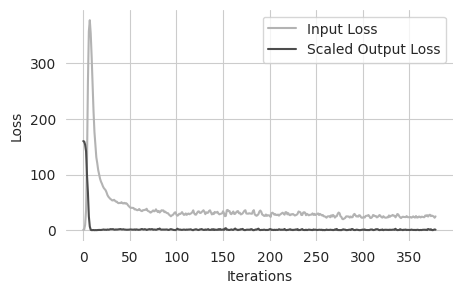

In [9]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

scaled_output_loss = numpy.array(history['output_loss']) * 10

plt.figure(figsize=(5, 3))
plt.plot(history['input_loss'], c='0.7', label="Input Loss")
plt.plot(scaled_output_loss, c='0.3', label="Scaled Output Loss")
plt.legend(fontsize=10)
plt.xlabel("Iterations")
plt.ylabel("Loss")

seaborn.despine(left=True, bottom=True)
plt.show()

Here, we are looking at the input and the scaled output loss during training. The input loss means the average number of edits proposed per sequence in that batch and the output loss is the average distance between the predictions from those edited sequences and the desired output, scaled by the inverse of lambda. This is an inversion of what happens inside Ledidi, where the input loss is scaled, just to preserve the simple connection between the input loss being the average number of edits for this visualization.

We can see that there are basically three regimes. In the first regime (the first \~7 iterations), the output loss rapidly decreases as edits are rapidly acquired. In the second regime (~7 to ~20 iterations), after the output loss becomes very small, the input loss rapidly decreases as useless edits are discarded. Finally, in the third regime (after ~20 iterations) the input loss slowly decreases as sets of edits with weak effects are exchanged for edits with stronger effects.

Overall, it looks like the design was a success, with only a few edits needed to achieve our goal. But let's directly check some things. First, let's check that the predictions are actually what we want. Once Ledidi has been fit, we can sample as many sets of edits as we want from the underlying distributions. These edits will be highly correlated with each other but give a sense for the distribution of predicted values they induce.

In [10]:
X_bar = torch.cat([wrapper(X) for _ in range(3)]) 
y_hat = predict(model, X_bar, device='cuda').numpy(force=True)

In theory, we can keep sampling from the forward function as long as we want, but 10 batches should be enough for now. Now we can plot the distribution of `y_hat`.

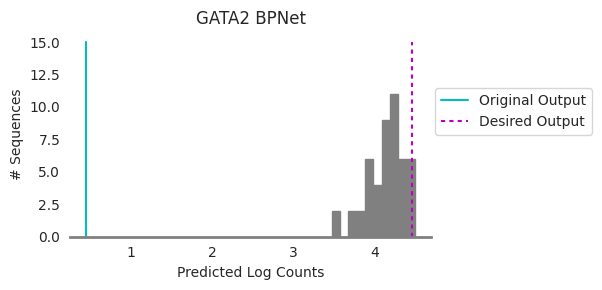

In [11]:
y1 = y_bar.numpy(force=True)[0, 0]
y0 = y1 - 4

plt.figure(figsize=(6, 3))
ax = plt.subplot(111)
plt.title("GATA2 BPNet")
plt.hist(y_hat, facecolor='0.5', edgecolor='0.5')
plt.plot([y0, y0], [0, 15], label="Original Output", c='c')
plt.plot([y1, y1], [0, 15], label="Desired Output", c='m', linestyle=(0, (2, 2)))

plt.legend(loc=(1.01, 0.5))
plt.xlabel("Predicted Log Counts")
plt.ylabel("# Sequences")
seaborn.despine(left=True)
plt.grid(False)
plt.setp(ax.spines.values(), linewidth=2, color='0.5')
    
    
plt.tight_layout()
plt.show()

We began with a sequence whose predicted log counts were at the cyan line and we wanted to generate a sequence whose predicted log counts were at the magenta line. Ledidi generated edits whose distribution is shown in gray. Looks like a pretty good match to the magenta line! Especially because we do not need each set of edits to match the desired output, just one of them.

Next, we can look at a map of where edits are made and when. Ledidi has a built-in function, `plot_edits`, that will show the entire history of where and when edits were proposed across the sequence. 

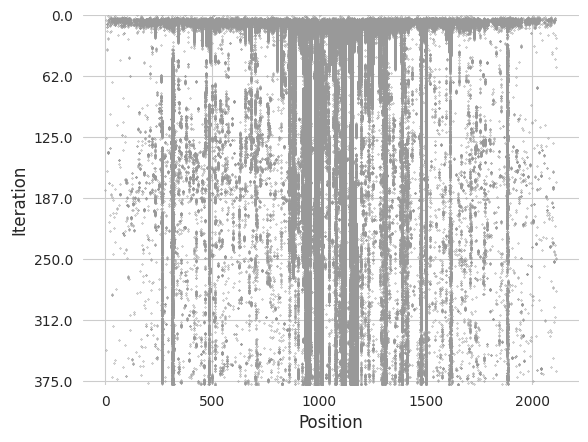

In [12]:
from ledidi.plot import plot_edits

plot_edits(history)
seaborn.despine(bottom=True, left=True)
plt.show()

Each gray dot represents an edit, with the top of the plot representing the beginning of the design process, the bottom representing the end of the design process, and the positions from left to right representing the positions in the sequence. Vertical streaks indicate positions where an edit has been proposed and then preserved and then sometimes discarded.

We see that the strongest trend is a mist of edits being proposed initially, lining up with the first regime of the plot shown earlier. Then, this mist starts to fade and vertical lines begin to appear. Most of the edits proposed by the end were already being proposed initially, and the thicker lines correspond to entire motifs being proposed. In contrast, some of the more spurious edits that are alone get adopted and then immediately discarded.

#### Pruning Edits

Despite Ledidi including the number of edits as an explicit term in the optimization, some edits that are proposed may only contribute marginally. These edits are likely to be phased out as regime 3 continues, but you can alternatively end this process early and prune them out using a built-in greedy pruning approach.

This greedy pruning approach proceeds as follows: undo each edit individually and record the change in prediction before and after undoing it. Then, undo the edit whose change in prediction is the smallest, provided that the total change in prediction from the original set of edits is no more than some user-provided threshold. Repeat this process until termination. 

In [13]:
from tqdm import tqdm
from ledidi.pruning import greedy_pruning

X_bar_p = torch.cat([greedy_pruning(model, X, xb[None], threshold=0.25, verbose=False) for xb in tqdm(X_bar)])

100%|██████████| 48/48 [00:04<00:00, 10.91it/s]


This process gets run independently for each set of edits that were proposed, hence the inner loop. We choose a threshold of 0.25, meaning that we will end up with a set of edits that are closer to being a log fold increase of 3.75 rather than 4.

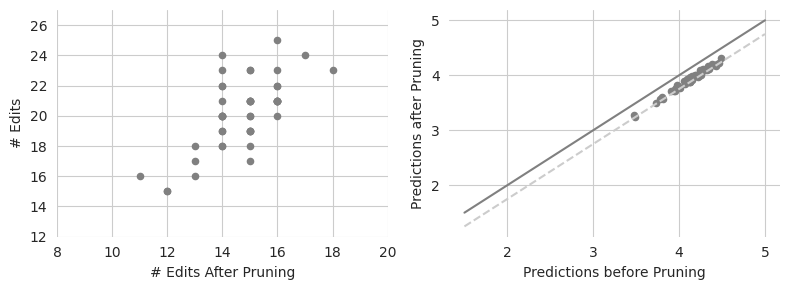

In [14]:
n_edits0 = torch.abs(X_bar - X).sum(dim=(-1, -2)).numpy(force=True) // 2
n_edits1 = torch.abs(X_bar_p - X).sum(dim=(-1, -2)).numpy(force=True) // 2

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(n_edits1, n_edits0, c='0.5', s=20)
plt.ylim(n_edits0.min() - 3, n_edits0.max() + 2)
plt.xlim(n_edits1.min() - 3, n_edits1.max() + 2)
plt.xlabel("# Edits After Pruning") 
plt.ylabel("# Edits")
seaborn.despine(bottom=True)
    
plt.subplot(122)
y_hat_ = predict(model, X_bar).numpy(force=True)
y_hat_pruned_ = predict(model, X_bar_p).numpy(force=True)

plt.scatter(y_hat_, y_hat_pruned_, s=20, c='0.5')
plt.plot([1.5, 5], [1.5, 5], c='0.5')
plt.plot([1.5, 5], [1.25, 4.75], c='0.8', linestyle='--')
plt.xlabel("Predictions before Pruning")
plt.ylabel("Predictions after Pruning")
seaborn.despine(bottom=True, left=True)


plt.tight_layout()
plt.show()

Looks like the pruning is able to remove quite a few edits, going from an average of around 30 edits to an average of around 16 edits. Some sequences seem to be able to be pruned quite a bit. As expected, none of these proposed sequences exhibit differences in prediction that exceed 0.5 (the dashed gray line) from their original predictions.

There is nothing special about a threshold of 0.25, though. In fact, we can great a gradient of edit counts by moving this threshold from 0 (no change from the original set of edits) to 4 (removing all the edits and going back to the original sequence). Looking at this gradient may be valuable for seeing how many edits we can undo without having to give up much. To speed things up we will only look at the first few sequences.

In [15]:
X_bar_hats, y_bar_hats = [], []

for j, threshold in enumerate(tqdm(numpy.arange(0.0, 4.1, 0.25))):
    X_bar_hat = greedy_pruning(model, X, X_bar[:1], threshold=threshold, verbose=False)
    X_bar_hats.append(X_bar_hat)
    
    y_bar_hat = predict(model, X_bar_hat)
    y_bar_hats.append(y_bar_hat)

X_bar_hats = torch.stack(X_bar_hats)
y_bar_hats = torch.stack(y_bar_hats)

n_edits0 = torch.abs(X_bar - X).sum(dim=(1, 2)).numpy(force=True) // 2
n_edits = torch.abs(X_bar_hats - X[None]).sum(dim=(2, 3)).numpy(force=True) // 2
y_dist = (y_bar_hats[:, :, 0]).numpy(force=True)

100%|██████████| 17/17 [00:02<00:00,  5.86it/s]


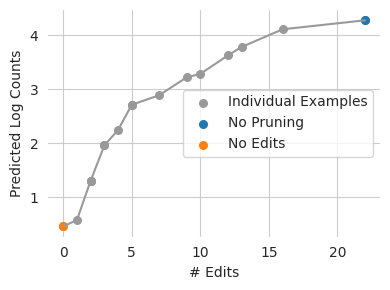

In [16]:
plt.figure(figsize=(4, 3))

plt.plot(n_edits.mean(axis=1), y_dist.mean(axis=1), c='0.6')
plt.scatter(n_edits.mean(axis=1), y_dist.mean(axis=1), c='0.6', s=30, label="Individual Examples")
plt.scatter([n_edits0[:1].mean()], [y_dist[0].mean()], s=30, label="No Pruning")
plt.scatter([0], [y_dist[-1].mean()], s=30, label="No Edits")

plt.legend(loc=5)
plt.xlabel("# Edits")
plt.ylabel("Predicted Log Counts")
plt.tight_layout()
seaborn.despine(bottom=True, left=True)
plt.show()

Looks like we would expect -- as Ledidi is allowed to keep more edits, the edited sequences get further away from the original predictions. It also looks like we can eliminate quite a few edits with only a minimal change in model prediction. This is likely because we are not spending enough time in that third regime, where weak edits are substituted for smaller sets of stronger ones.

### Inspecting Edits using Attributions

So far we have designed edits, shown that they seem to make sense globally, and seen how we can prune them to achieve more compact sets that still seem to perform well on global measures. However, we have not yet inspected these edits and the pruning results to see whether they make biological sense.

A simple way to inspect these sequences is to use an attribution algorithm like DeepLIFT/SHAP, which will highlight the nucleotides and motifs that drive model predictions. We can calculate attributions for the original unedited sequence, the set of edits that were originally proposed, and the pruned set of edits.

In [17]:
from tangermeme.deep_lift_shap import deep_lift_shap

X_attr = deep_lift_shap(model, X, verbose=True, random_state=0).numpy(force=True)
X_attr2 = deep_lift_shap(model, X_bar, verbose=True, random_state=0).numpy(force=True)
X_attr3 = deep_lift_shap(model, X_bar_p, verbose=True, random_state=0).numpy(force=True)

100%|██████████| 960/960 [00:01<00:00, 934.97it/s]


Now, we can take a look at these attributions, highlighting the sets of edits that are made with respect to the original sequence.

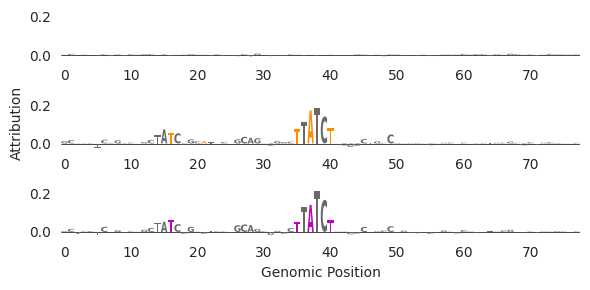

In [18]:
import pandas
import logomaker

def plot_edits2(Xs, axs, colors='darkorange'):
    ymax = max([X.max() for X in Xs]) * 1.1
    ymin = min([X.min() for X in Xs]) * 1.1

    idxs0 = (Xs[0] != 0).argmax(axis=0)
    alpha = numpy.array(['A', 'C', 'G', 'T'])
    
    for i, (X, ax) in enumerate(zip(Xs, axs)):
        c = colors if isinstance(colors, str) else colors[i]
        
        idx = (X != 0).argmax(axis=0)
        diff = [alpha[i1] if i0 != i1 else 'N' for i0, i1 in zip(idxs0, idx)]
        diff = ''.join(diff)
        
        df = pandas.DataFrame(X.T, columns=['A', 'C', 'G', 'T'])
        df.index.name = 'pos'
        
        df = df.astype('float64')
        
        logo = logomaker.Logo(df, ax=ax, color_scheme='dimgrey')
        logo.style_spines(visible=False)
        logo.style_glyphs_in_sequence(sequence=diff, color=c)
        ax.set_ylim(ymin, ymax)
        ax.grid(False)
        
        seaborn.despine(bottom=True, left=True)
        
mid = X_attr2[2].sum(axis=0).argmax()
w = 40
start, end = mid - w + 2, mid + w

xa0 = X_attr[0, :, start:end]
xa1 = X_attr2[2, :, start:end]
xa2 = X_attr3[2, :, start:end]

plt.figure(figsize=(6, 3))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
plt.ylabel("Attribution")
ax3 = plt.subplot(313)

plot_edits2([xa0, xa1, xa2], [ax1, ax2, ax3], colors=['k', 'darkorange', 'm'])

plt.xlabel("Genomic Position")
plt.tight_layout()

There are a few things to note here. First, the original sequence (top row) has no high-attribution characters here, suggesting that before edits there is no GATA binding. Second, it looks like the main span of high attribution characters after edits (middle row)is a GATAA motif (but reverse-complemented, so TTATC -> GATAA). This makes sense because we are trying to design GATA2 binding sites. Third, it looks like the pruning (bottom row) got rid of two of the low-attribution characters (the G just next to the A edit on the right side of the motif, and the T on the left side of the motif), as well as a G that is off on the right side. 

Finally, it is somewhat remarkable that this was able to be done in so few edits. Rather than simply implanting the GATA2 motif somewhere in the sequence and calling it a day, Ledidi found a region that was almost a GATA2 motif and added the final characters. This speaks to the precision that Ledidi is able to operate at, where the input loss forces Ledidi to find the best site to turn into a binding site in addition to the right edits that need to be made. Put another way, Ledidi makes the length of the motif be the maximum number of edits needed to unlock the power of implanting that motif and frequently uses far fewer than that number. Sometimes you may need multiple motif copies, in which case the total edits is longer than one motif instance, but the number of edits will be less than the multiplication of the number of motif copies and the length of the motif.

Next, let's take a look at the pruning. We can cross-reference the pruning and the attributions to see which edits are kept.

In [21]:
print("X_bar:", X_bar.shape, X_bar.device)
print("X:", X.shape, X.device)
print("X_attr2:", X_attr2.shape, X_attr2.device)

X_bar: torch.Size([48, 4, 2114]) cuda:0
X: torch.Size([1, 4, 2114]) cuda:0
X_attr2: (48, 4, 2114) cpu


In [23]:
orig_edits = (torch.abs(X_bar - X).sum(dim=-2) != 0).cpu().detach().numpy().flatten()
pruned_edits = (torch.abs(X_bar_p - X).sum(dim=-2) != 0).cpu().detach().numpy().flatten()

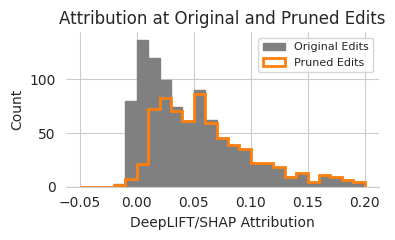

In [25]:
# orig_edits = (torch.abs(X_bar - X).sum(dim=-2) != 0).numpy(force=True).flatten()
# pruned_edits = (torch.abs(X_bar_p - X).sum(dim=-2) != 0).numpy(force=True).flatten()

orig_edits_attr = X_attr2.sum(axis=1).flatten()[orig_edits]
pruned_edits_attr = X_attr2.sum(axis=1).flatten()[pruned_edits]

plt.figure(figsize=(4, 2.5))
plt.hist(orig_edits_attr, bins=numpy.arange(-0.05, 0.21, 0.01), facecolor='0.5', edgecolor='0.5', label="Original Edits")
plt.hist(pruned_edits_attr, bins=numpy.arange(-0.05, 0.21, 0.01), histtype='step', label="Pruned Edits", linewidth=2)

plt.legend(fontsize=8)
plt.title("Attribution at Original and Pruned Edits")
plt.xlabel("DeepLIFT/SHAP Attribution")
plt.ylabel("Count")
plt.tight_layout()
seaborn.despine(left=True)
plt.show()

It looks like, as one might expect, that the edits with high attribution are the ones kept by the pruning algorithm and the ones with low attribution are generally the one discarded. This is not a perfect overlap, with some of the discarded edits having higher attribution than some of the kept ones, but the trend is pretty clear. Potentially, one could use attributions as a fast approximation for the edits to keep or to prioritize within the pruning algorithm which ones should not even be checked because they have such high attribution.

### Inspecting Edits using Motif Hits

Intuitively, we would expect that at least some of the edits proposed by Ledidi would match known binding motifs for the proteins whose binding we are trying to increase. Of course, these known motifs are not perfect and may be subject to more complicated cis-regulatory rules in specific cellular contexts, but if there are no increases in hits for a known motif than we might be suspicious that the edits might have caused some weird out-of-distribution behavior in the model.

We can check whether the edits create more motif binding sites using FIMO, which scans a PWM against a sequence and then converts this convolution score (the dot product between the PWM and the one-hot encoded sequence) into a p-value that a threshold can be applied against.

First, we load up the JASPAR database. Because it is so large and redundant, for the purpose of this demonstration we just choose a few known proteins -- GATA because we are expecting hits for that, and several others to use as "decoys" who should not have increased motif counts -- and scan those using FIMO.

In [26]:
from tangermeme.io import read_meme
from tangermeme.tools.fimo import fimo
from tangermeme.plot import plot_pwm

motifs = read_meme("JASPAR2024_CORE_non-redundant_pfms_meme.txt")
motif_names = numpy.array(list(motifs.keys()))

motif_subnames = 'GATA', 'CTCF', 'E2F3', 'MAX', 'KLF', 'POU5F1'
motif_subset = [[name for name in motif_names if name_subset in name][0] for name_subset in motif_subnames]

motifs = {name: motifs[name] for name in motif_subset}
motif_names = numpy.array(list(motifs.keys()))
motif_pwms = list(motifs.values())

Now, we can scan the sequences before and after incorporating the edits and count the number of motif instances for each of these motifs. 

In [27]:
hits_before = fimo(motifs, X, return_counts=True, threshold=0.001)
hits_after = fimo(motifs, X_bar_p, return_counts=True, threshold=0.001) / len(X_bar_p)

hits_diff = hits_after - hits_before
hits_idxs = hits_diff.argsort()

And we can visualize this difference...

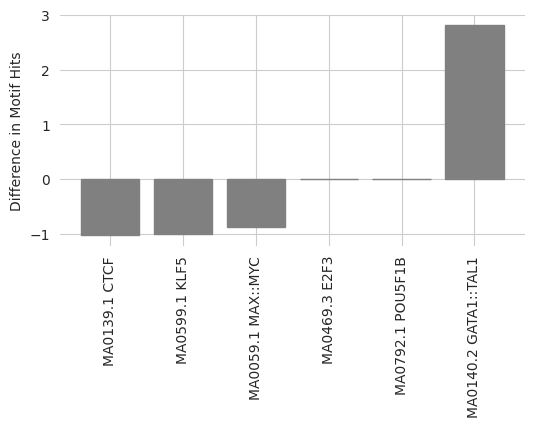

In [28]:
plt.figure(figsize=(6, 3))
plt.bar(range(6), hits_diff[hits_idxs], facecolor='0.5', edgecolor='0.5')
plt.ylabel("Difference in Motif Hits") 

plt.xticks(range(6), motif_names[hits_idxs], rotation=90)
seaborn.despine(bottom=True, left=True)
plt.show()

Looks like there is a big increase in the number of GATA binding sites, and a decrease in the number of other sorts of binding sites. This makes sense, as Ledidi is potentially converting other binding sites into GATA2 sites because this design task is not concerned with preserving these other forms of activity.

### Confirming with Other Models

Finally, we can confirm these edits are generalizable by seeing whether other models make predictions consistent with our editing objective. First, we can see whether Enformer predicts higher GATA2 binding after including the edits than with the original sequence.

In [29]:
from enformer_pytorch import from_pretrained

class EnformerWrapper(torch.nn.Module):
    def __init__(self, model, target):
        super(EnformerWrapper, self).__init__()
        self.model = model
        self.target = target
    
    def forward(self, X):
        y = self.model(X[:, :, 33:-33].permute(0, 2, 1))['human']
        return torch.log(y.sum(dim=1)[:, self.target:self.target+1] + 1)
    
enformer_base = from_pretrained('EleutherAI/enformer-official-rough', target_length=16, use_tf_gamma=False)
enformer = EnformerWrapper(enformer_base, 1392)

predict(enformer, X), predict(enformer, X_bar).mean(), predict(enformer, X_bar_p).mean()

/home1/smaruj/miniconda3/envs/pytorch_cuda11.8/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(tensor([[3.8463]]), tensor(4.7462), tensor(4.7012))

It looks like the edits also increase predictions from Enformer and that the pruned edits likewise reduce the predicted value. This suggests that not only are the edits generalizable but the pruning algorithm is actually finding edits that do not actually matter that much. Note that we would not expect that the edits yield the exact same difference in prediction, i.e., increasing the predicted value by exactly 4, because the outputs are actually different between the two models. So, the validation is more directional in nature.

When proteins bind to DNA they almost always increase chromatin accessibility. Accordingly, a more indirect way to evaluate these edits is to see whether they also induce an increase in predicted chromatin accessibility. We can do this using a few different models, as chromatin accessibility is generally more broadly modeled.

First, we can use Enformer again but with the DNase head instead of the TF ChIP-seq head.

In [30]:
enformer = EnformerWrapper(enformer_base, 121)

predict(enformer, X), predict(enformer, X_bar).mean(), predict(enformer, X_bar_p).mean()

(tensor([[3.1924]]), tensor(3.7759), tensor(3.7554))

Great, looks like we are seeing an increase -- albeit somewhat small -- in accessibility here too.

Next, to use a model that is more similar in output, architecture, and training scheme, we can use a BPNet model that is trained to predict ATAC-seq reads. This is not exactly ChromBPNet because it does not contain the bias model, but that component is less necessary for predicting read counts as opposed to the base-pair resolution profiles.  

In [ ]:
# bpnet_atac = torch.load("../../models/bpnet/ATAC-control.torch", weights_only=False)
# bpnet_atac = CountWrapper(ControlWrapper(bpnet_atac))

# predict(bpnet_atac, X), predict(bpnet_atac, X_bar).mean(), predict(bpnet_atac, X_bar_p).mean()

Looks like we see a similar result here too, with a small but noticable increase in accessibility. Both Enformer and this model seem to suggest that the region is already somewhat accessible and so the addition of GATA binding does not fundamentally change its openness.

### Conclusions

Put together, these results indicate that Ledidi is a fast and precise way to edit sequencs using pre-trained models. This tutorial notebook is meant to be an introduction to the the algorithm with code examples to get you started, as well as some ideas for how to validate your edits once you make them. For more complex design ideas using Ledidi, please see the subsequent notebooks.